## Problem Statement

We have been given a PDE: du/dx=2du/dt+u

            ut + lamda* u * ux + beta * uxx + gamma * uxxxx = 0
and boundary condition:

- Independent variables: x,t (input)
- Dependent variables: u (outputs)


We have to find out u(x,t) for all x in range [0,2] and t in range [0,1]


When we solved this problem analytically, we found the solution: u(x,t) = 6e^(-3x-2t)


Our f is f = ut + lamda* u * ux + beta * uxx + gamma * uxxxx

In [10]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
!nvidia-smi

Sun Feb 25 12:04:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [12]:
import numpy as np


In [13]:
# We consider Net as our solution u_theta(x,t)

"""
When forming the network, we have to keep in mind the number of inputs and outputs
In ur case: #inputs = 2 (x,t)
and #outputs = 1

You can add as many hidden layers as you want with as many neurons.
More complex the network, the more prepared it is to find complex solutions, but it also requires more data.

Let us create this network:
min 5 hidden layer with 5 neurons each.
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,5)
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5)
        self.hidden_layer4 = nn.Linear(5,5)
        self.hidden_layer5 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out) ## For regression, no activation is used in output layer
        return output

In [14]:
### (2) Model
net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters())

In [15]:
## PDE as loss function. Thus would use the network which we call as u_theta
def f(x,t, net):
    u = net(x,t) # the dependent variable u is given by the network based on independent variables x,t
    ## Based on our f = du/dx - 2du/dt - u, we need du/dx and du/dt
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx.sum(), x, create_graph=True)[0]
    u_xxxx = torch.autograd.grad(u_xxx.sum(), x, create_graph=True)[0]

    pde = u_t + u*u_x + u_xx + u_xxxx
    return pde

In [16]:
## Data from Boundary Conditions
# u(x,0)=6e^(-3x)
## BC just gives us datapoints for training

# BC tells us that for any x in range[0,2] and time=0, the value of u is given by 6e^(-3x)
# Take say 500 random numbers of x
x_bc = np.random.uniform(low=0.0, high=2.0, size=(500,1))
t_bc = np.zeros((500,1))
# compute u based on BC
u_bc = 6*np.exp(-3*x_bc)

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

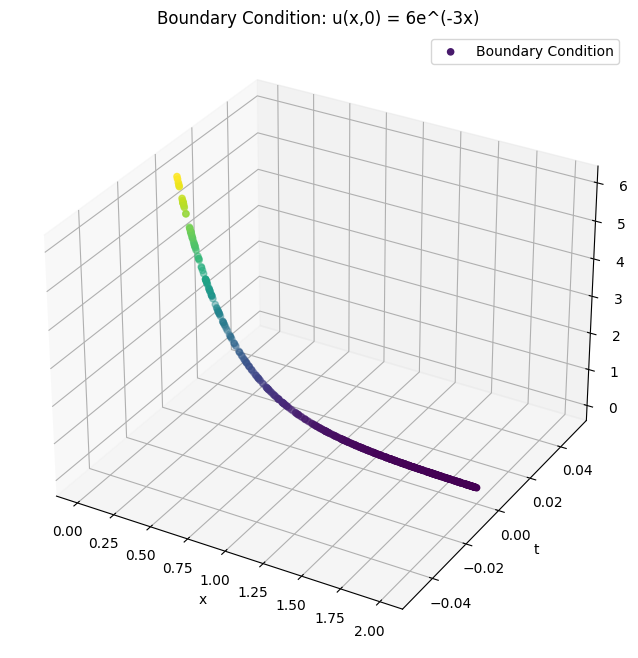

In [24]:


# Generate random x values in the range [0, 2]
x_bc = np.random.uniform(low=0.0, high=2.0, size=(500,))
t_bc = np.zeros_like(x_bc)  # Time is 0 for boundary condition
u_bc = 6 * np.exp(-3 * x_bc)  # Compute u based on boundary condition

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(x_bc, t_bc, u_bc, c=u_bc, cmap='viridis', label='Boundary Condition')

# Set labels
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.set_title('Boundary Condition: u(x,0) = 6e^(-3x)')

plt.legend()
plt.show()



In [17]:
### (3) Training / Fitting
iterations = 20000
previous_validation_loss = 99999999.0
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero

    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)

    net_bc_out = net(pt_x_bc, pt_t_bc) # output of u(x,t)
    mse_u = mse_cost_function(net_bc_out, pt_u_bc)

    # Loss based on PDE
    x_collocation = np.random.uniform(low=0.0, high=2.0, size=(500,1))
    t_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1))
    all_zeros = np.zeros((500,1))


    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)

    f_out = f(pt_x_collocation, pt_t_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)

    # Combining the loss functions
    loss = mse_u + mse_f


    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    with torch.autograd.no_grad():
    	print(epoch,"Traning Loss:",loss.data)


Streaming output truncated to the last 5000 lines.
15000 Traning Loss: tensor(0.6873, device='cuda:0')
15001 Traning Loss: tensor(0.6450, device='cuda:0')
15002 Traning Loss: tensor(0.6919, device='cuda:0')
15003 Traning Loss: tensor(0.6330, device='cuda:0')
15004 Traning Loss: tensor(0.6469, device='cuda:0')
15005 Traning Loss: tensor(0.6768, device='cuda:0')
15006 Traning Loss: tensor(0.6577, device='cuda:0')
15007 Traning Loss: tensor(0.6613, device='cuda:0')
15008 Traning Loss: tensor(0.6465, device='cuda:0')
15009 Traning Loss: tensor(0.6328, device='cuda:0')
15010 Traning Loss: tensor(0.6456, device='cuda:0')
15011 Traning Loss: tensor(0.6343, device='cuda:0')
15012 Traning Loss: tensor(0.6589, device='cuda:0')
15013 Traning Loss: tensor(0.7002, device='cuda:0')
15014 Traning Loss: tensor(0.6512, device='cuda:0')
15015 Traning Loss: tensor(0.6901, device='cuda:0')
15016 Traning Loss: tensor(0.6761, device='cuda:0')
15017 Traning Loss: tensor(0.6797, device='cuda:0')
15018 Traning

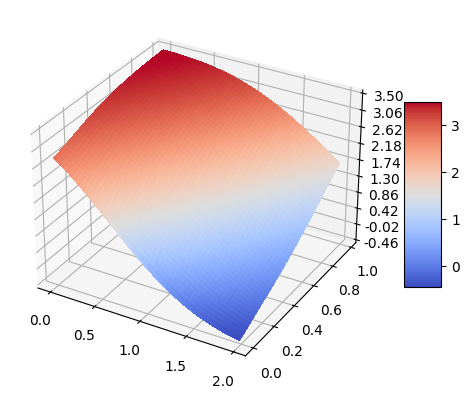

In [27]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

x=np.arange(0,2,0.02)
t=np.arange(0,1,0.02)
ms_x, ms_t = np.meshgrid(x, t)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = net(pt_x, pt_t)
u = pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x, ms_t, ms_u, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


In [28]:
# Save Model
torch.save(net.state_dict(), "model_uxt.pt")